In [4]:
from openpyxl import load_workbook
from pathlib import Path

In [54]:
home = Path.cwd()
path = home/'Sample Data.xlsx'

In [55]:
my_excel_file = Path.home() / home/'Sample Data.xlsx'
wb = load_workbook(my_excel_file)
ws = wb.worksheets[0]

In [56]:
sample_name = ws['a2'].value
width = ws['b2'].value
thickness = ws['c2'].value

In [5]:
def sample_data_read (file_name: str):
    '''
    Reads sample metadata from the first worksheet of an Excel file.

    Parameters
    ----------
    file_name : str
        The name of the Excel file to read, located in the current working directory.

    Returns
    -------
    list
        A list containing:
        - sample_file_name (sample name from cell A2 with ".csv" extension)
        - thickness (value from cell C2)
        - width (value from cell B2)
    '''
    
    from openpyxl import load_workbook
    from pathlib import Path
    sample_data_file = Path.cwd()/file_name
    wb = load_workbook(sample_data_file)
    ws = wb.worksheets[0]
    sample_name = ws['a2'].value
    width = ws['b2'].value
    thickness = ws['c2'].value
    sample_file_name = str (sample_name + ".csv")
    return [sample_file_name, thickness, width]

In [19]:
S = sample_data_read('Sample data.xlsx')

In [20]:
type(S)

list

In [21]:
S[2]

'S1.csv'

In [1]:
import struct_post.postanalysis as pa

In [2]:
S1 = pa.sample_data_read("Sample Data.xlsx")

In [3]:
S1['thickness']

10

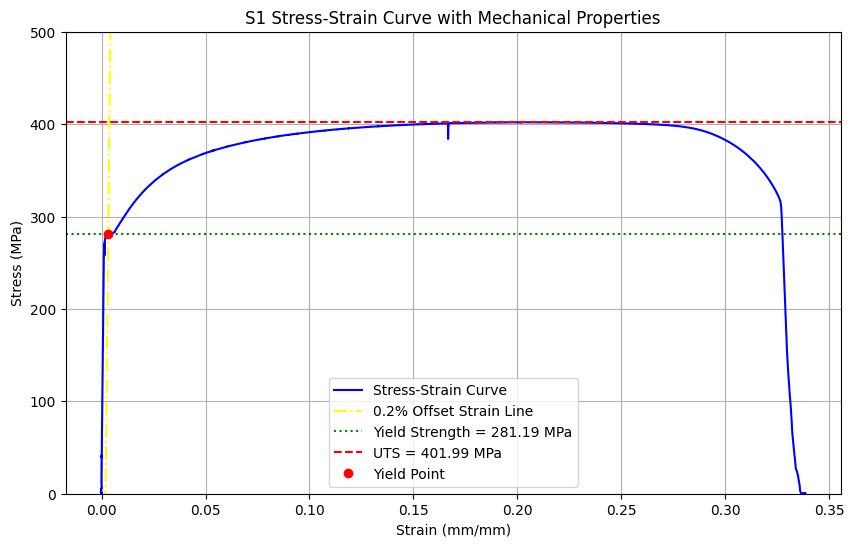

Young's Modulus (E): 219.53 GPa
Ultimate Tensile Strength (UTS): 401.99 MPa
Yield Strength: 281.19 MPa


('S1',
 <Figure size 1000x600 with 1 Axes>,
 {'E_GPa': np.float64(219.5329298272338),
  'UTS_MPa': np.float64(401.98968479999996),
  'Yield_Strength_MPa': np.float64(281.1899679365556)})

In [5]:
pa.coupon_test(S1['sample_file_name'],S1['thickness'],S1['width'])

Young's Modulus is: 219532.9298272338 MPa
Intercept: 24.077713061365355 MPa


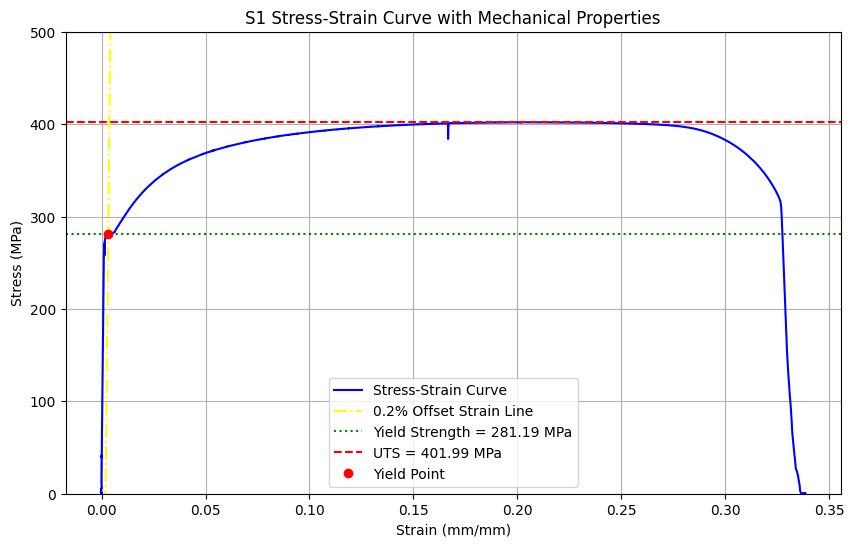

Young's Modulus (E): 219.53 GPa
Ultimate Tensile Strength (UTS): 401.99 MPa
Yield Strength: 281.19 MPa


('S1',
 <Figure size 1000x600 with 1 Axes>,
 {'E_GPa': np.float64(219.5329298272338),
  'UTS_MPa': np.float64(401.98968479999996),
  'Yield_Strength_MPa': np.float64(281.1899679365556)})

In [23]:
pa.coupon_test(S[0], S[1], S[2])

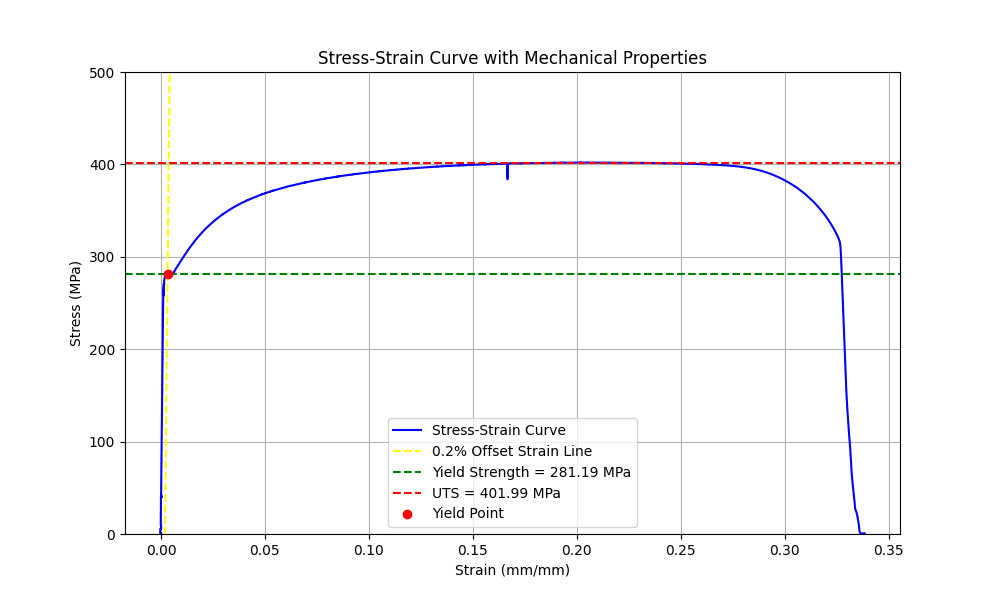

Young's Modulus (E): 219.53 GPa
Ultimate Tensile Strength (UTS): 401.99 MPa
Yield Strength: 281.19 MPa


('testdata',
 <Figure size 1000x600 with 1 Axes>,
 {'E_GPa': np.float64(219.5329298272338),
  'UTS_MPa': np.float64(401.98968479999996),
  'Yield_Strength_MPa': np.float64(281.1899679365556)})

In [19]:
coupon_test(S[1],S[2])

In [17]:
def coupon_test (thickness: float = 2.5, 
                 width: float = 10, 
                 file_name: str = 'testdata.csv',
                 lower_bound: float = 0.1, 
                 upper_bound: float = 0.3):
    """
    Post-process a tensile coupon test and plot stress-strain curve.
    
    Args:
        Thickness (float): Specimen thickness in mm.
        Width (float): Specimen width in mm.
        file_name (str): CSV file containing test data.
        low_bound (float): Lower bound of elastic region as fraction of UTS.
        upper_bound (float): Upper bound of elastic region as fraction of UTS.
        save_path (str, optional): Path to save the figure. If None, do not save.

    Returns:
        fig (matplotlib.figure.Figure): Figure object containing the plot.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib widget
    # Constants
    thickness # mm
    width # mm
    area = thickness * width  # Calculate the area of the specimen
    
    # Load tensile test data
    df = pd.read_csv(file_name, header=[0])
    
    #df.columns = [f"{col[0]} {col[1]}" for col in df.columns]
    
    # Extract relevant columns
    #time = df["Time (sec)"]
    #displacement = df["Crosshead separation (mm)"]
    force = df[df.columns[1]]
    elongation = df[df.columns[2]]
    strain = elongation # Strain in mm/mm
    
    # Calculate stress and strain
    force = force * 1000 # Convert kN to N
    stress = (force / area)  # N/m^2 or Pa
    uts = stress.max()
    
    #find the data before uts
    idx_peak = np.argmax(stress)
    strain_up = strain[:idx_peak+1]
    stress_up = stress[:idx_peak+1]
    
    #Boundary for 20% - 50% of UTS
    lower_bound = 0.1 * uts
    upper_bound = 0.3 * uts
    
    elastic_reg = (lower_bound <= stress_up) & (stress_up <= upper_bound)
    
    stress_ela = stress_up[elastic_reg]
    strain_ela = strain_up[elastic_reg] 
    
    E, intercept = np.polyfit(strain_ela, stress_ela, 1)
    #print(f"Young's Modulus is: {E} MPa",)
    E_GPa = E / 1000  # Convert MPa to GPa
    #print(f"Intercept: {intercept} MPa")
   
    # Select over 30% of UTS, as yield stress will over 30% uts
    strain_new = elongation
    stress_new = force / area
    mask = (lower_bound <= stress)
    strain_mask = strain_new[mask]
    stress_mask = stress_new[mask]
    
    offset_decimal = 0.002  # 0.2% in decimal
    offset_line = E * (strain_new - offset_decimal) + intercept

    #Find the Yield strength
    diff = stress_mask - offset_line
    cross_index = np.where(diff <= 0)[0][0] 
    x1 = strain_mask[cross_index-1]
    x2 = strain_mask[cross_index]
    y1 = diff[cross_index-1]
    y2 = diff[cross_index]
    yield_strain = x1 - y1 * (x2 - x1) / (y2 - y1)
    yield_strength = np.interp(yield_strain, strain_new, stress_new)

    #Plot
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot(strain, stress, label='Stress-Strain Curve', color='blue')
    ax.plot(strain_new, offset_line, label='0.2% Offset Strain Line', color='yellow',linestyle = '--')
    

    
    ax.axhline(y=yield_strength, label=f'Yield Strength = {yield_strength:.2f} MPa', color='green', linestyle = '--')
    ax.axhline(y=uts, color='red', linestyle = '--', label=f'UTS = {uts:.2f} MPa')
    ax.plot(yield_strain, yield_strength, 'ro', label='Yield Point')
    
    ax.set_xlabel('Strain (mm/mm)')
    ax.set_ylabel('Stress (MPa)')
    ax.set_title('Stress-Strain Curve with Mechanical Properties')
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0, 500)
    plt.show()
    # Print results
    print(f"Young's Modulus (E): {E_GPa:.2f} GPa")
    print(f"Ultimate Tensile Strength (UTS): {uts:.2f} MPa")
    print(f"Yield Strength: {yield_strength:.2f} MPa")

    
    # Prepare results dictionary
    results = {
        "E_GPa": E_GPa,
        "UTS_MPa": uts,
        "Yield_Strength_MPa": yield_strength
    }
    #results = [E_GPa, uts, yield_strength]
    return file_name[:-4], fig, results

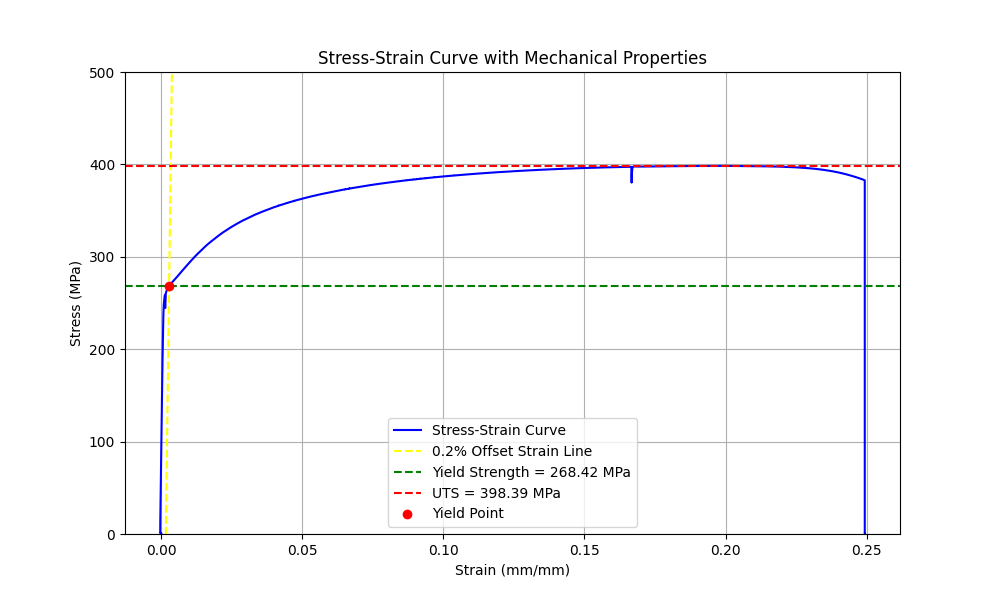

Young's Modulus (E): 232.08 GPa
Ultimate Tensile Strength (UTS): 398.39 MPa
Yield Strength: 268.42 MPa


In [63]:
C = coupon_test(thickness=thickness, width=width, file_name='C-2DPS-2.csv')

In [64]:
C[2]

{'E_GPa': np.float64(232.08231183965586),
 'UTS_MPa': np.float64(398.39423719999996),
 'Yield_Strength_MPa': np.float64(268.42295107315533)}

In [67]:
for col, value in enumerate(C[2].values(), start=4):
    ws.cell(row=2, column=col, value=float(value))
wb.save(path)  # 覆盖保存

In [5]:
from dataclasses import dataclass

In [6]:
@dataclass # this thing is called a "decorator"
class SampleDetails:
    """
    Doc string
    """
    sample_name: str
    width: float
    thickness: float
    sample_file_name: str

In [7]:
@dataclass # this thing is called a "decorator"
class SampleAnalysisResults:
    """
    Doc string
    """
    sample_name: str
    modulus_of_elasticity: float
    ultimate_tensile_strength: float
    yield_Strength: float

In [15]:
sample_data_file = Path.cwd()/'Sample Data.xlsx'
wb = load_workbook(sample_data_file)
ws = wb.worksheets[0]
samples = []
for row in ws.iter_rows(min_row=2, values_only=True):  
    if all(cell is None for cell in row):  # skip empty
        continue
    # 取前三列数据
    sample_name = SampleDetails(row[0], row[1], row[2])
    samples.append(sample_name)


In [16]:
for s in samples:
    print(s)

SampleDetails(sample_name='S1', width=2.5, thickness=10)
SampleDetails(sample_name='S2', width=3, thickness=10.55)


In [25]:
samples[0].sample_name

'S1'

In [34]:
def sample_data_read (file_name: str):
    '''
    Reads sample metadata from the first worksheet of an Excel file.

    Parameters
    ----------
    file_name : str
        The name of the Excel file to read, located in the current working directory.

    Returns
    -------
    list
        A list containing:
        - sample_file_name (sample name from cell A2 with ".csv" extension)
        - thickness (value from cell C2)
        - width (value from cell B2)
    '''
    
    from openpyxl import load_workbook
    from pathlib import Path
    sample_data_file = Path.cwd()/file_name
    wb = load_workbook(sample_data_file)
    ws = wb.worksheets[0]
    samples = []
    for row in ws.iter_rows(min_row=2, values_only=True):  
        if all(cell is None for cell in row):  # skip empty
            continue
        # 取前三列数据
        sample_file_name = str (row[0] + ".csv")
        sample_name = SampleDetails(row[0], row[1], row[2], sample_file_name)
        samples.append(sample_name)
    return samples

In [1]:
import struct_post.postanalysis as pa

In [3]:
raws = pa.sample_data_read('Sample Data.xlsx')

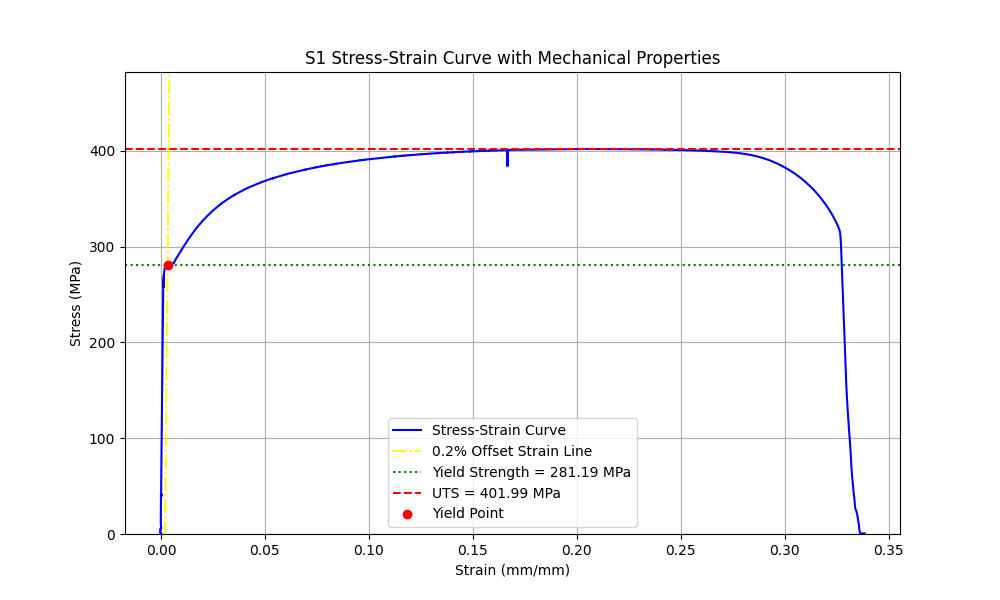

Young's Modulus (E): 219.53 GPa
Ultimate Tensile Strength (UTS): 401.99 MPa
Yield Strength: 281.19 MPa


In [19]:
coupon_result = pa.coupon_test_analysis(raws[0].sample_file_name,raws[0].thickness,raws[0].width)

In [26]:
coupon_result[0]

'S1'

In [46]:
SAR = SampleAnalysisResults(coupon_result[0], coupon_result[2]['E_GPa'],  coupon_result[2]['UTS_MPa'], coupon_result[2]['Yield_Strength_MPa'])

In [47]:
SAR

SampleAnalysisResults(sample_name='S1', modulus_of_elasticity=np.float64(219.5329298272338), ultimate_tensile_strength=np.float64(401.98968479999996), yield_Strength=np.float64(281.1899679365556))

In [15]:
from openpyxl import load_workbook

# 打开 Excel
path = 'Sample Data.xlsx'
wb = load_workbook(path)
ws = wb.worksheets[0]

for row_idx, row in enumerate(ws.iter_rows(min_row=2, max_col=ws.max_column), start=2):
    excel_sample_name = row[0].value  # 假设 A 列是 sample_name
    # 遍历 SARS 列表，找到对应 sample_name
    for SAR in SARS:
        if SAR.sample_name == excel_sample_name:
            values_to_write = [
                SAR.modulus_of_elasticity,
                SAR.ultimate_tensile_strength,
                SAR.yield_Strength
            ]
            for col_idx, value in enumerate(values_to_write, start=4):  # 从 D 列开始
                ws.cell(row=row_idx, column=col_idx, value=float(value))
            break  # 找到匹配的 sample_name 就跳出 SARS 循环

# 保存覆盖原文件
wb.save(path)

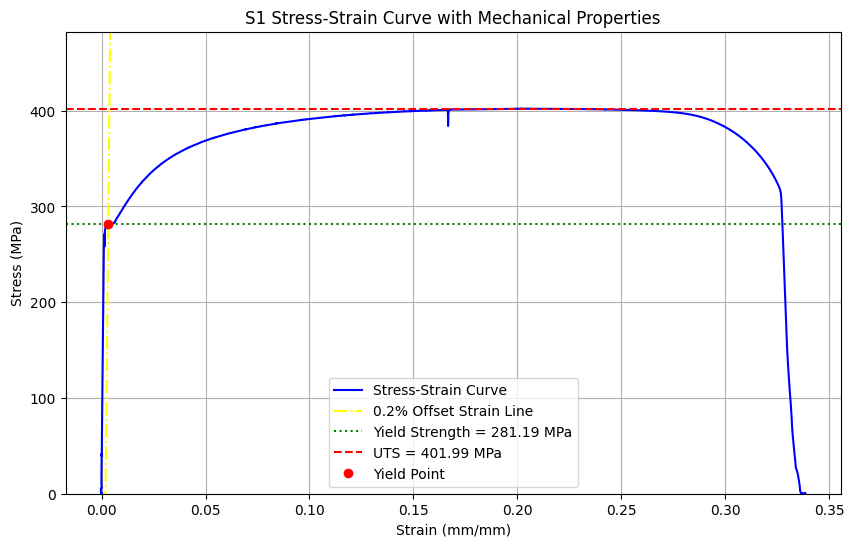

Young's Modulus (E): 219.53 GPa
Ultimate Tensile Strength (UTS): 401.99 MPa
Yield Strength: 281.19 MPa


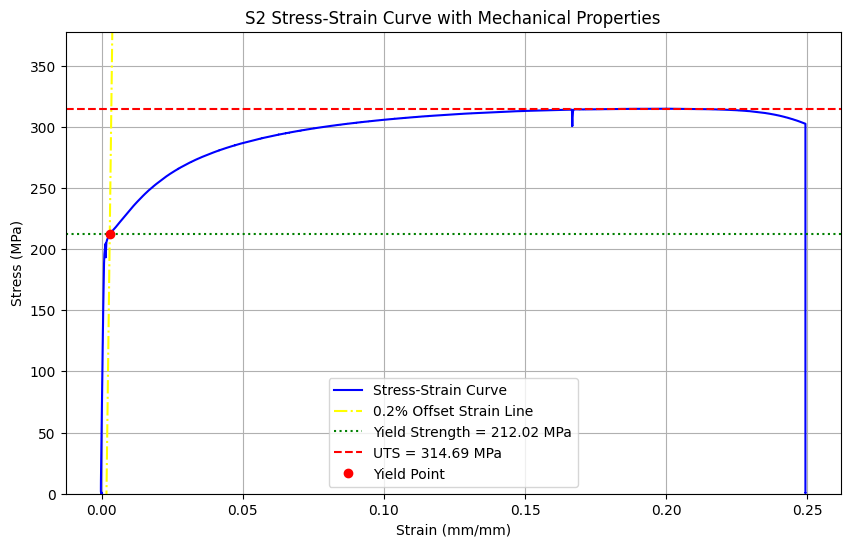

Young's Modulus (E): 183.32 GPa
Ultimate Tensile Strength (UTS): 314.69 MPa
Yield Strength: 212.02 MPa


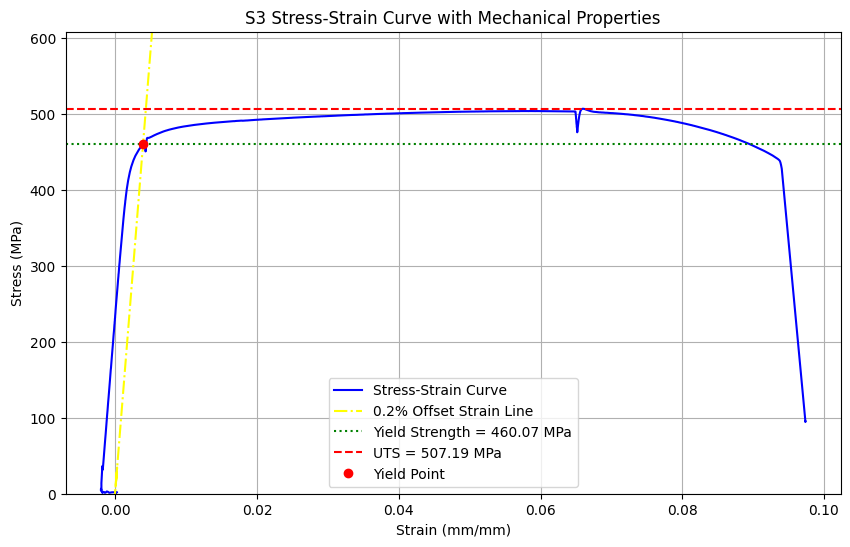

Young's Modulus (E): 116.48 GPa
Ultimate Tensile Strength (UTS): 507.19 MPa
Yield Strength: 460.07 MPa


In [8]:
SARS = []
for raw in raws:
    result = pa.coupon_test_analysis(raw.sample_file_name, raw.thickness, raw.width)
    SAR = SampleAnalysisResults(result[0], result[2]['E_GPa'], result[2]['UTS_MPa'], result[2]['Yield_Strength_MPa'])
    SARS.append(SAR)

In [9]:
SARS

[SampleAnalysisResults(sample_name='S1', modulus_of_elasticity=np.float64(219.5329298272338), ultimate_tensile_strength=np.float64(401.98968479999996), yield_Strength=np.float64(281.1899679365556)),
 SampleAnalysisResults(sample_name='S2', modulus_of_elasticity=np.float64(183.31936164269823), ultimate_tensile_strength=np.float64(314.68739115323854), yield_Strength=np.float64(212.02444792508317)),
 SampleAnalysisResults(sample_name='S3', modulus_of_elasticity=np.float64(116.48144457700757), ultimate_tensile_strength=np.float64(507.1875170625), yield_Strength=np.float64(460.0694249789463))]